# Шахматные онлайн-партии

К текущему датасету добавим новый атрибут - difference_rating
Он будет обозначать разницу в рейтинге между игроком за белые фигуры и игроком за черные (может быть отрицательным в том случае, если у игрока черными рейтинг больше, чем у игрока белыми).

Из текущего датасета удалим выбросы (выбросы определены в первой работе).
Необходимо убрать все партии, где количество ходов превышает 135 ходов, а также все партии где рейтинг одного из игроков меньше 850 или больше 2350.

Пропущенных значений нет.

Для выделения групп, уменьшим количество исследуемых партий, чтобы они были визуально различимы на графике. Также поправим данные, чтобы при кластеризации алгоритмом KMeans было меньше растекания.

In [2]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.cluster import KMeans
import numpy as np 
import plotly.graph_objs as go
import plotly as py

In [68]:
with open("chess_games.csv", encoding='utf-8') as r_file:
    file_reader = csv.reader(r_file, delimiter=",")
    count = 0
    data = []
    for row in file_reader:
        if count == 150:
            break
        if count > 50:
            if (int(row[2]) <= 135) & (int(row[7]) >= 850) & (int(row[9]) >= 850) & (int(row[7]) <= 2350) & (int(row[9]) <= 2350):
                data = data + [(row[0], row[1], row[2], row[3], row[4], row[5], row[6], int(row[7])/10, row[8], int(row[9])/10, 
                                (int(row[7]) - int(row[9]))/10)]
        count += 1   
    
with open("chess_games_filtered.csv", mode="w", encoding='utf-8') as w_file:
    file_writer = csv.writer(w_file, delimiter=",", lineterminator="\r")
    file_writer.writerow( 
        ["game_id", "rated", "turns", "victory_status", "winner", "time_increment", "white_id",
         "white_rating", "black_id", "black_rating", "difference_rating"])
    file_writer.writerows(data) 

In [69]:
games = pd.read_csv('chess_games_filtered.csv')
games.describe()

,game_id,rated,turns,winner,white_rating,black_rating,difference_rating
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,99.402062,0.938144,52.247423,0.541237,151.134021,148.735052,2.398969
std,28.565225,0.242145,29.509896,0.493025,22.907390,23.347435,21.221253
min,51.000000,0.000000,2.000000,0.000000,97.800000,92.100000,-52.600000
25%,75.000000,1.000000,33.000000,0.000000,131.600000,128.200000,-7.000000
50%,99.000000,1.000000,48.000000,1.000000,153.900000,151.200000,1.700000
75%,124.000000,1.000000,64.000000,1.000000,172.100000,163.100000,11.800000
max,148.000000,1.000000,135.000000,1.000000,203.600000,210.500000,78.100000


## Графики зависимости

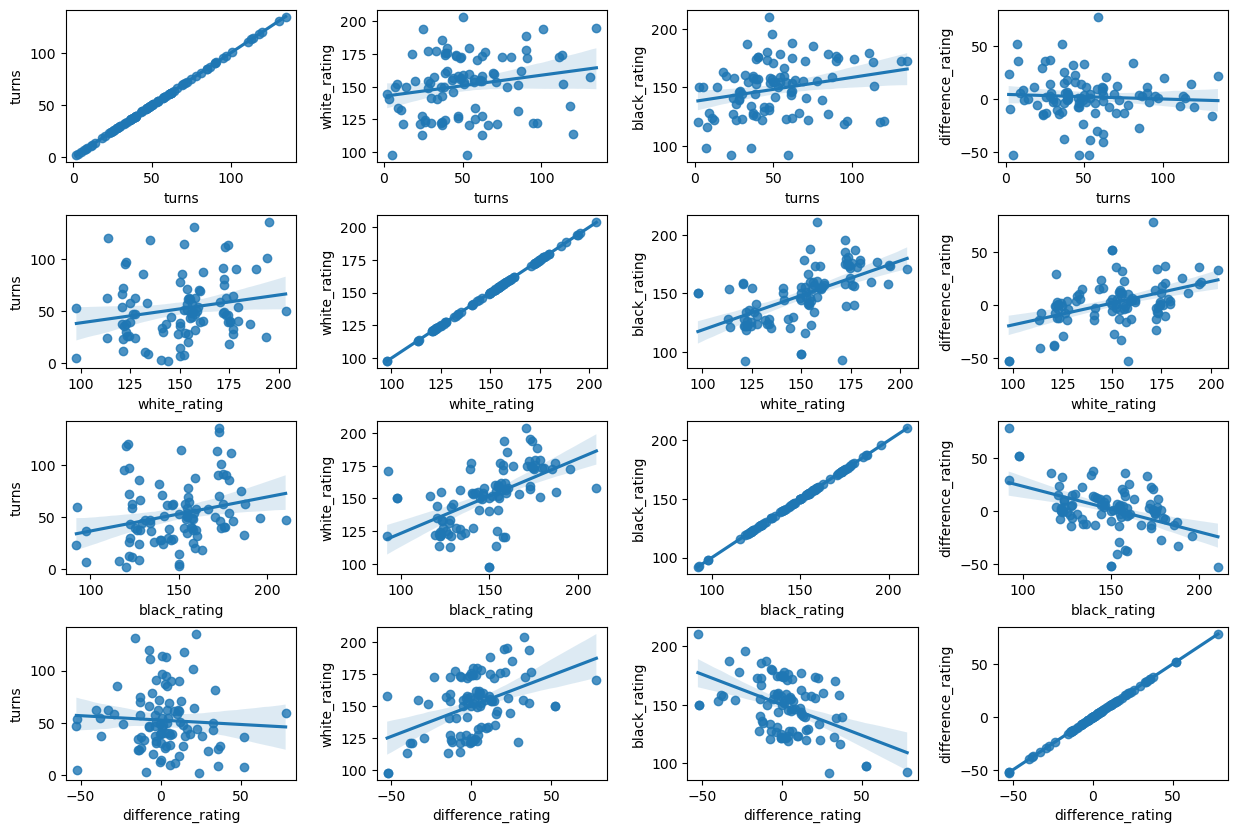

In [71]:
plt.figure(1 , figsize = (15 , 10))
n = 0 
for x in ['turns' , 'white_rating', 'black_rating', 'difference_rating']:
    for y in ['turns' , 'white_rating', 'black_rating', 'difference_rating']:
        n += 1
        plt.subplot(4 , 4 , n)
        plt.subplots_adjust(hspace = 0.35 , wspace = 0.35)
        sns.regplot(x = x , y = y , data = games)        
plt.show()

Из представленных графиков, только на одном из них можно предположить две ярковыраженные группы - на графике turns/difference_rating 
При количестве ходов меньше 80 - первая группа,
При количестве ходов больше либо равном 80 - вторая группа.

График зависимости количества ходов от разницы рейтинга, раскрашенный в зависимости от того, является ли игра рейтинговой:

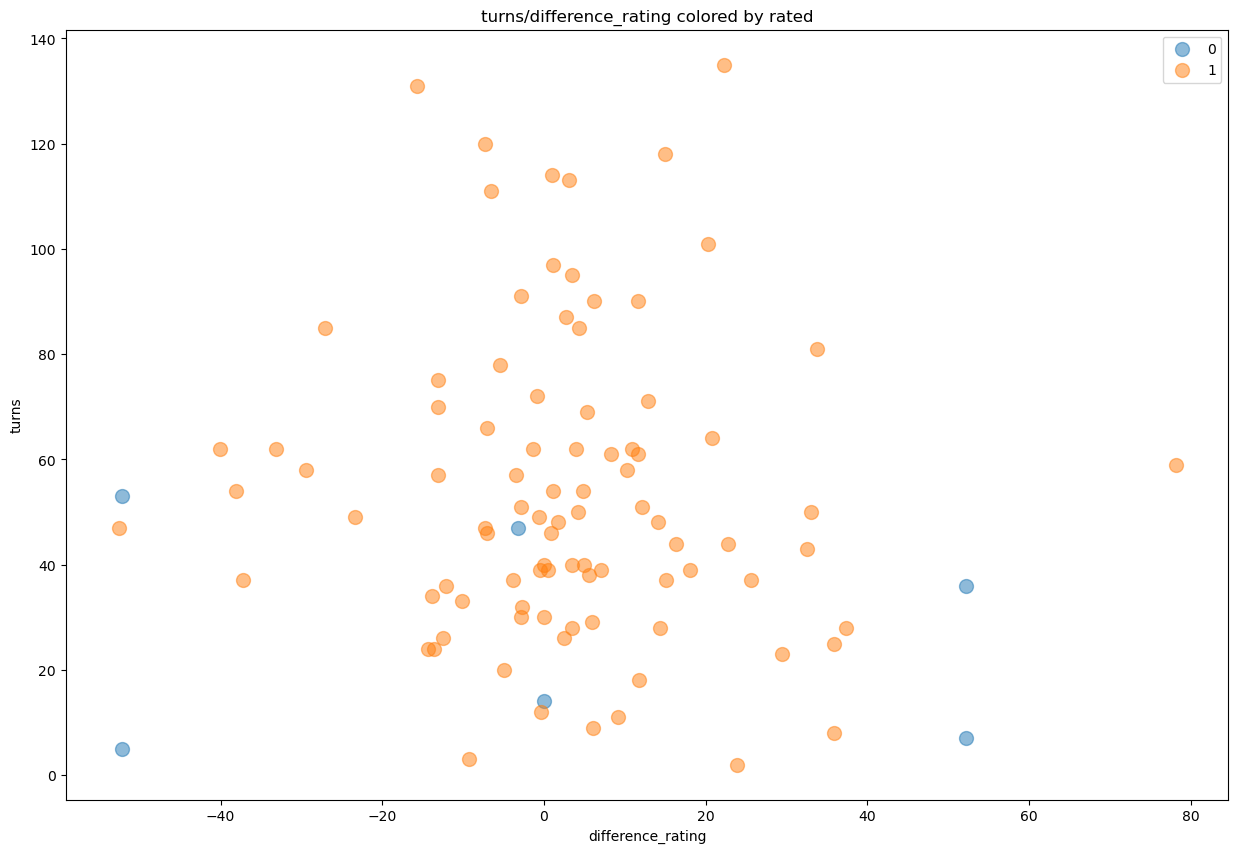

In [62]:
plt.figure(1 , figsize = (15 , 10))
for rated in [0, 1]:
    plt.scatter(x = 'difference_rating' , y = 'turns' , data = games[(games['rated'] == rated)] ,
                s = 100 , alpha = 0.5 , label = rated)
plt.xlabel('difference_rating'), plt.ylabel('turns') 
plt.title('turns/difference_rating colored by rated')
plt.legend(loc='upper right')
plt.show()

График зависимости количества ходов от разницы рейтинга, раскрашенный в зависимости от того, кем выиграна партия:

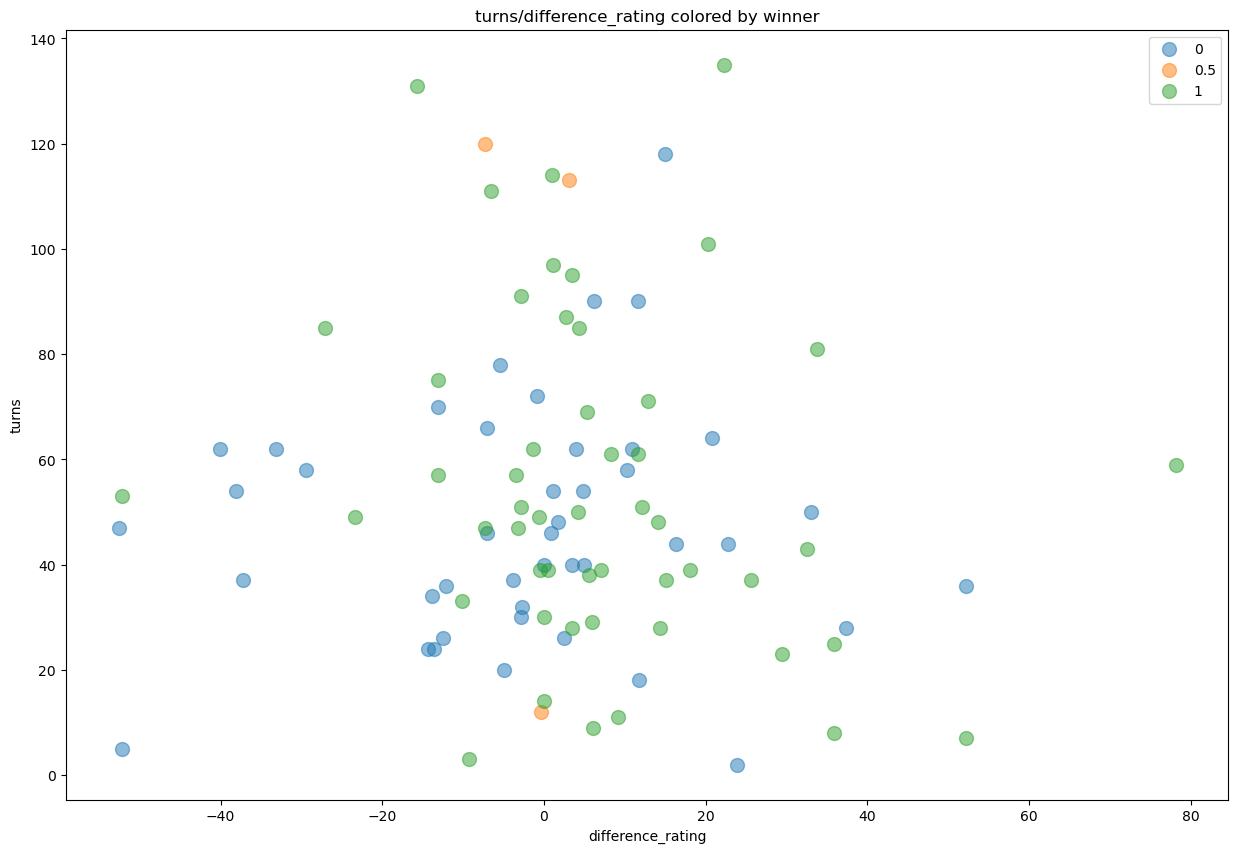

In [72]:
plt.figure(1 , figsize = (15 , 10))
for winner in [0, 0.5, 1]:
    plt.scatter(x = 'difference_rating' , y = 'turns' , data = games[(games['winner'] == winner)] ,
                s = 100 , alpha = 0.5 , label = winner)
plt.xlabel('difference_rating'), plt.ylabel('turns') 
plt.title('turns/difference_rating colored by winner')
plt.legend(loc='upper right')
plt.show()

На данном графике видно, что победы игроков за черные фигуры чаще приходятся на левую часть графика, а победы игроков за белые фигуры чаще приходятся на правую часть графика, таким образом можно предоположить наличие двух кластеров.

График зависимости количества ходов от рейтинга игрока за черные, раскрашенный в зависимости от того, является ли игра рейтинговой:

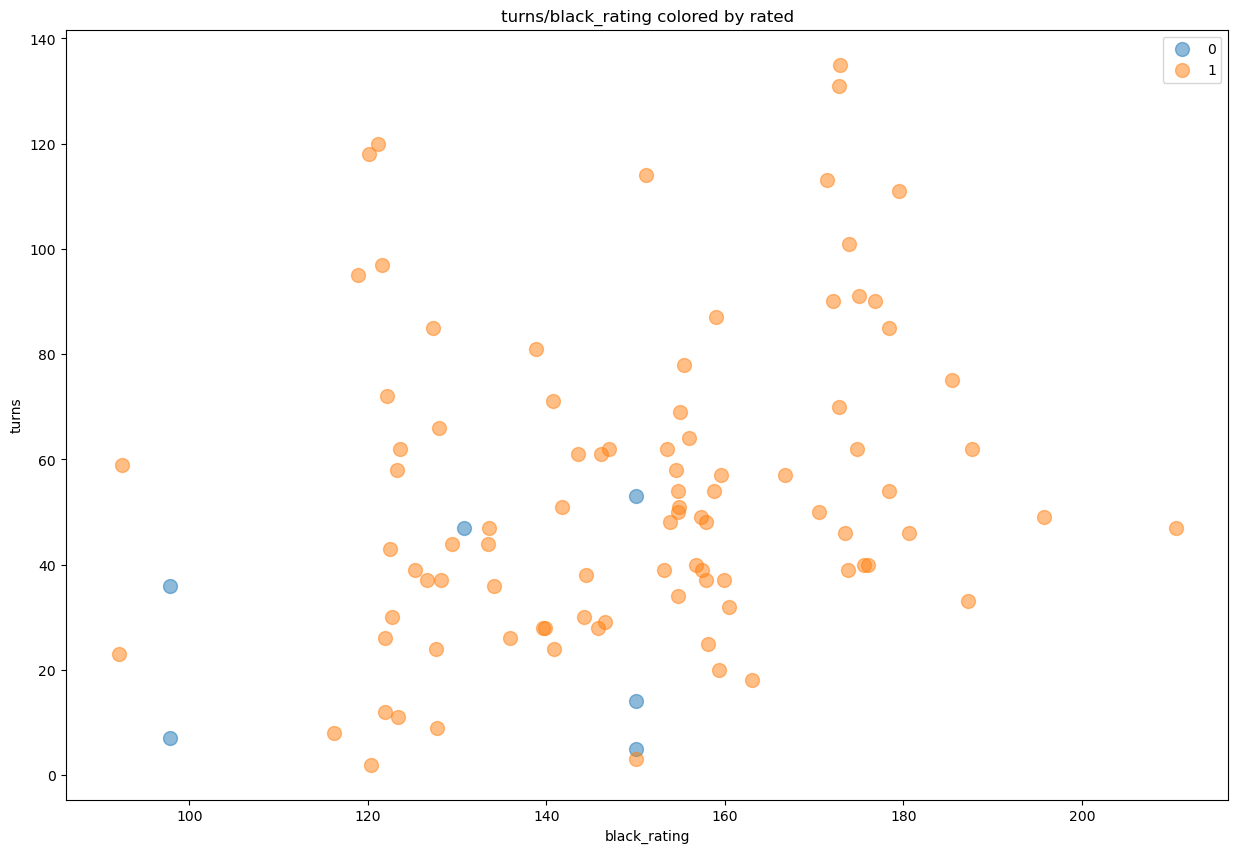

In [73]:
plt.figure(1 , figsize = (15 , 10))
for rated in [0, 1]:
    plt.scatter(x = 'black_rating' , y = 'turns' , data = games[(games['rated'] == rated)] ,
                s = 100 , alpha = 0.5 , label = rated)
plt.xlabel('black_rating'), plt.ylabel('turns') 
plt.title('turns/black_rating colored by rated')
plt.legend(loc='upper right')
plt.show()

График зависимости количества ходов от рейтинга игрока за черные, раскрашенный в зависимости от того, кем выиграна партия:

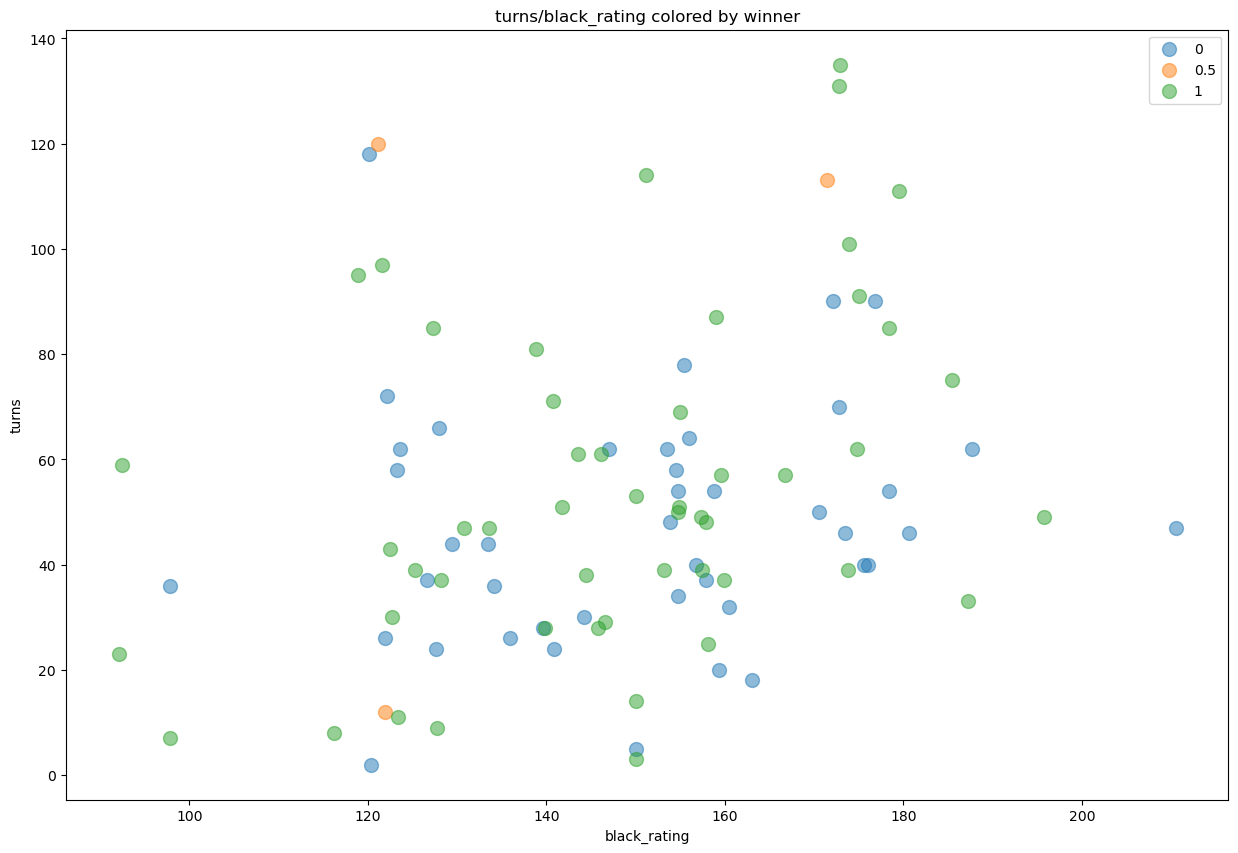

In [74]:
plt.figure(1 , figsize = (15 , 10))
for winner in [0, 0.5, 1]:
    plt.scatter(x = 'black_rating' , y = 'turns' , data = games[(games['winner'] == winner)] ,
                s = 100 , alpha = 0.5 , label = winner)
plt.xlabel('black_rating'), plt.ylabel('turns') 
plt.title('turns/black_rating colored by winner')
plt.legend(loc='upper right')
plt.show()

График зависимости разницы рейтинга от рейтинга игрока за белые, раскрашенный в зависимости от того, является ли игра рейтинговой:

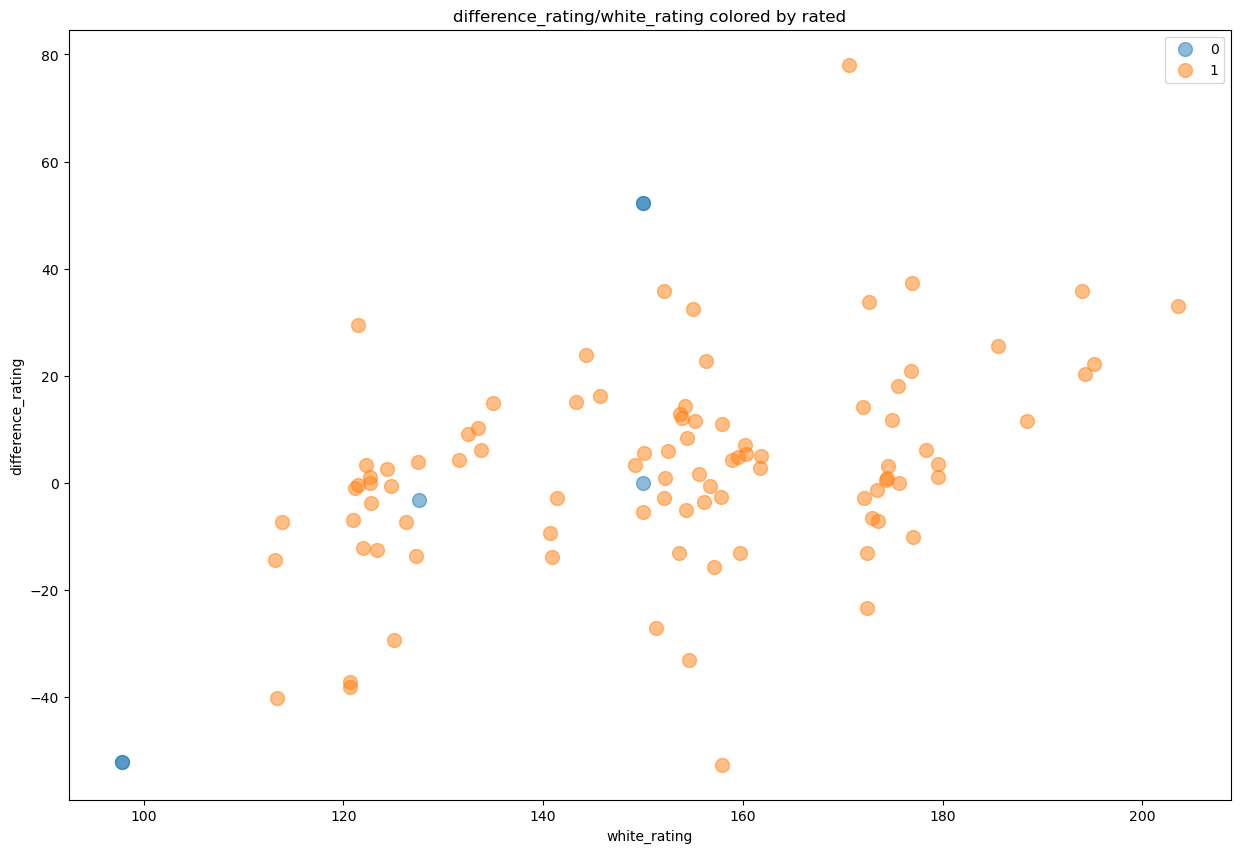

In [75]:
plt.figure(1 , figsize = (15 , 10))
for rated in [0, 1]:
    plt.scatter(x = 'white_rating' , y = 'difference_rating' , data = games[(games['rated'] == rated)] ,
                s = 100 , alpha = 0.5 , label = rated)
plt.xlabel('white_rating'), plt.ylabel('difference_rating') 
plt.title('difference_rating/white_rating colored by rated')
plt.legend(loc='upper right')
plt.show()

График зависимости разницы рейтинга от рейтинга игрока за белые, раскрашенный в зависимости от того, кем выиграна партия:

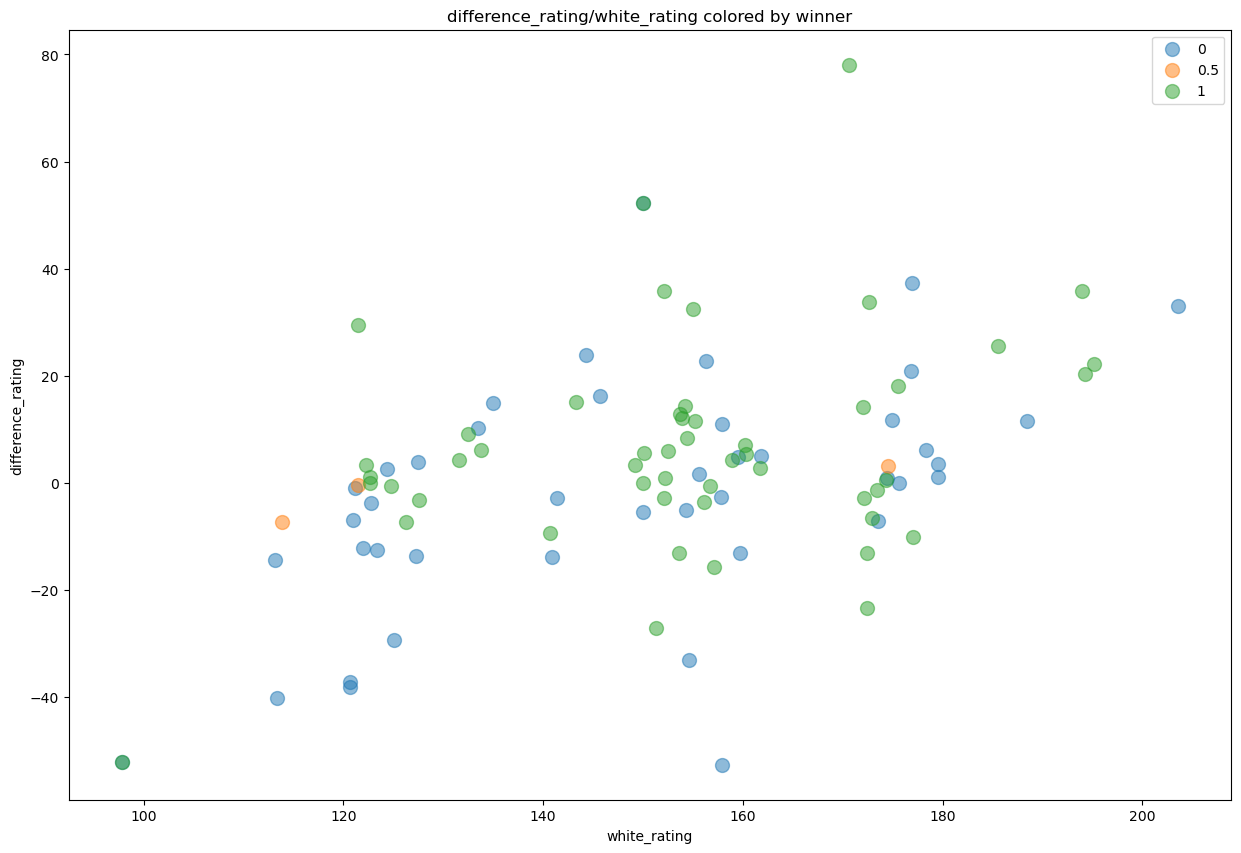

In [76]:
plt.figure(1 , figsize = (15 , 10))
for winner in [0, 0.5, 1]:
    plt.scatter(x = 'white_rating' , y = 'difference_rating' , data = games[(games['winner'] == winner)] ,
                s = 100 , alpha = 0.5 , label = winner)
plt.xlabel('white_rating'), plt.ylabel('difference_rating') 
plt.title('difference_rating/white_rating colored by winner')
plt.legend(loc='upper right')
plt.show()

## KMeans

Выделим кластеры между атрибутами turns и difference_rating

In [88]:
X1 = games[['difference_rating', 'turns']].iloc[: , :].values
inertia = []
for n in range(1 , 15):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=100, 
                        tol=0.01,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)

D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1373: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


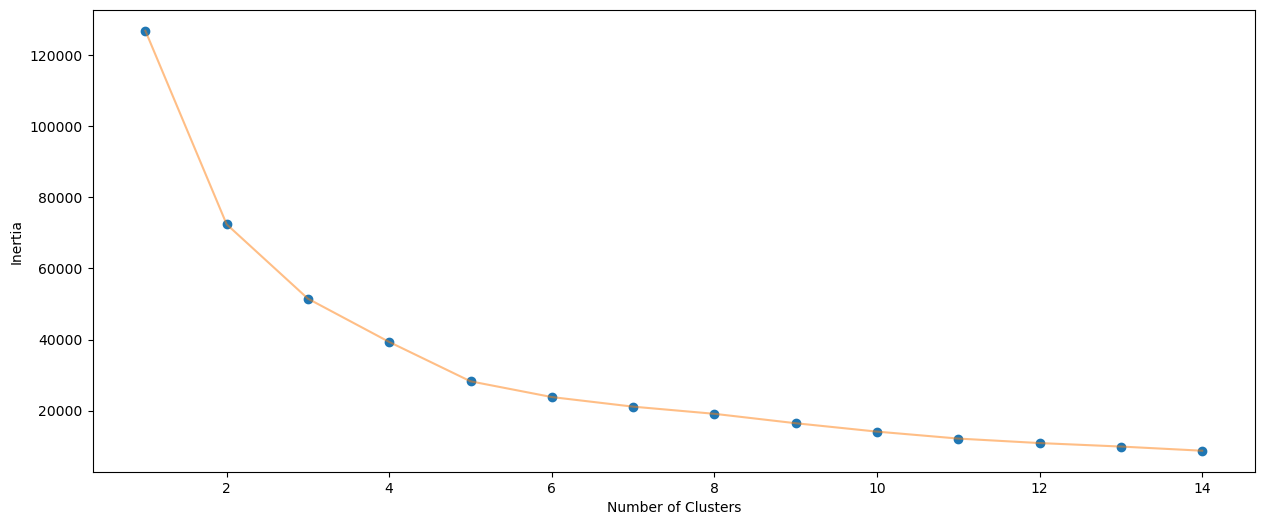

In [89]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 15) , inertia , 'o')
plt.plot(np.arange(1 , 15) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [90]:
algorithm = (KMeans(n_clusters = 5 ,init='k-means++', n_init = 10 ,max_iter=100, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X1)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

In [91]:
h = 0.25
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()]) 

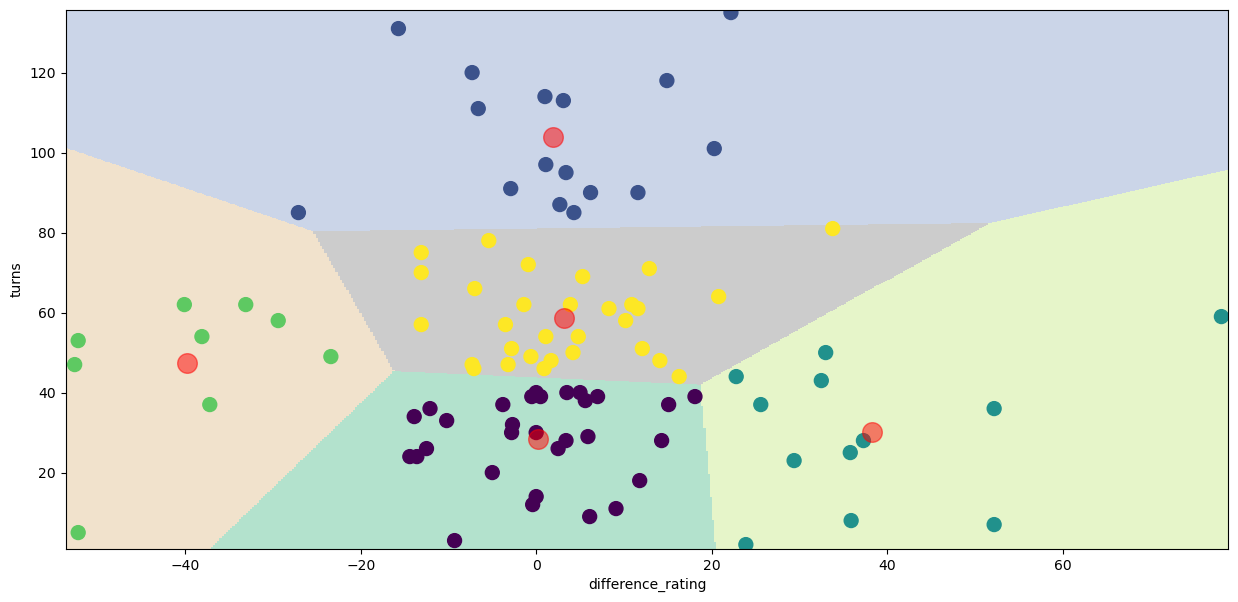

In [92]:
plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'difference_rating' ,y = 'turns' , data = games , c = labels1 , 
            s = 100 )
plt.scatter(x = centroids1[: , 0] , y =  centroids1[: , 1] , s = 200 , c = 'red' , alpha = 0.5)
plt.ylabel('turns') , plt.xlabel('difference_rating')
plt.show()

Выделим кластеры между атрибутами turns и black_rating

In [93]:
X1 = games[['black_rating', 'turns']].iloc[: , :].values
inertia = []
for n in range(1 , 15):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=100, 
                        tol=0.01,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)

D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1373: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


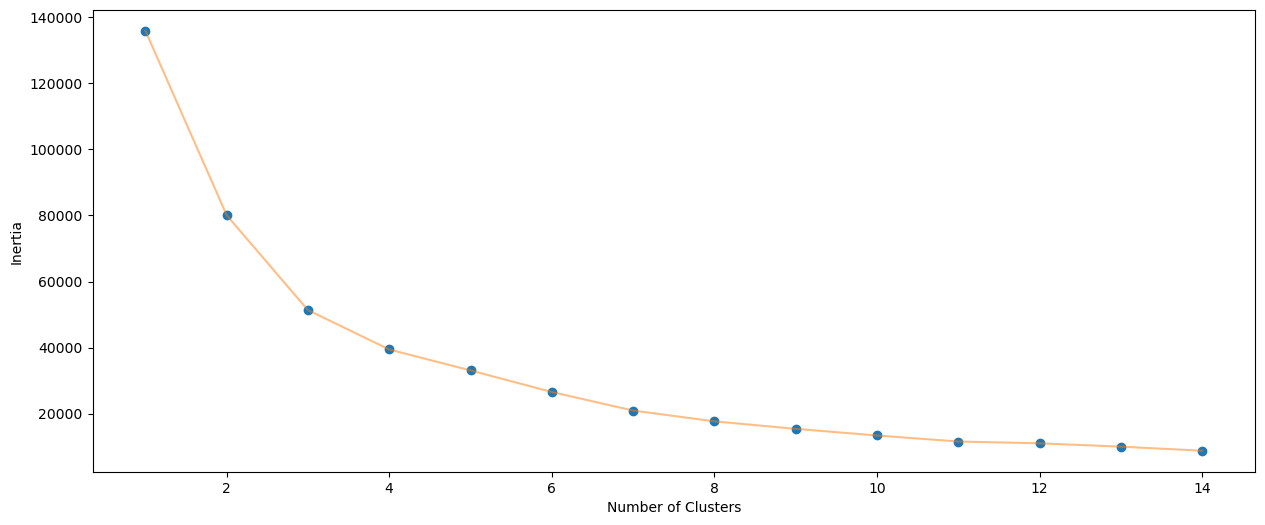

In [94]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 15) , inertia , 'o')
plt.plot(np.arange(1 , 15) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [95]:
algorithm = (KMeans(n_clusters = 5 ,init='k-means++', n_init = 10 ,max_iter=100, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X1)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

In [96]:
h = 0.25
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()]) 

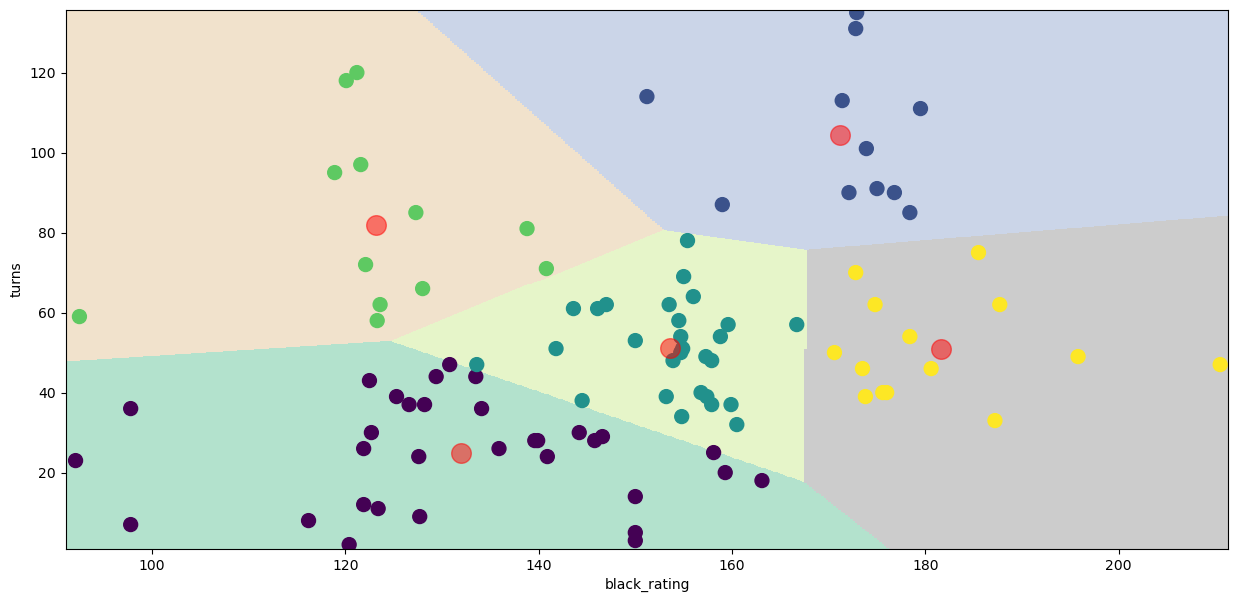

In [97]:
plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'black_rating' ,y = 'turns' , data = games , c = labels1 , 
            s = 100 )
plt.scatter(x = centroids1[: , 0] , y =  centroids1[: , 1] , s = 200 , c = 'red' , alpha = 0.5)
plt.ylabel('turns') , plt.xlabel('black_rating')
plt.show()

Выделим кластеры между атрибутами white_rating и difference_rating  

In [108]:
X1 = games[['difference_rating', 'white_rating']].iloc[: , :].values
inertia = []
for n in range(1 , 15):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=100, 
                        tol=0.01,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)

D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1373: RuntimeWarning: algorithm='elkan' doesn't make sense for a single cluster. Using 'lloyd' instead.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


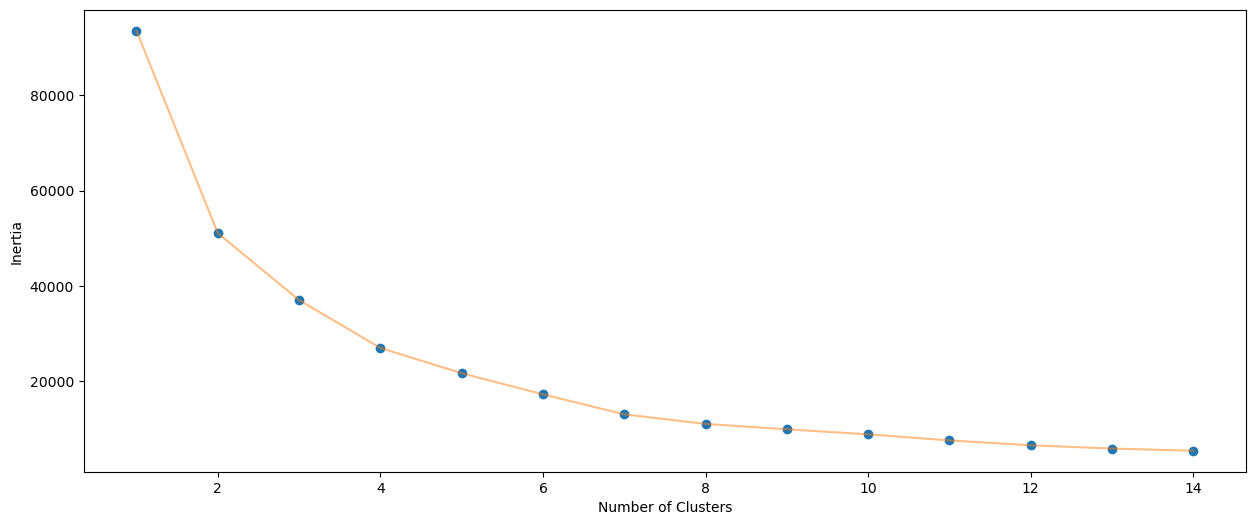

In [109]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 15) , inertia , 'o')
plt.plot(np.arange(1 , 15) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [110]:
algorithm = (KMeans(n_clusters = 5 ,init='k-means++', n_init = 10 ,max_iter=100, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X1)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

In [111]:
h = 0.25
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()]) 

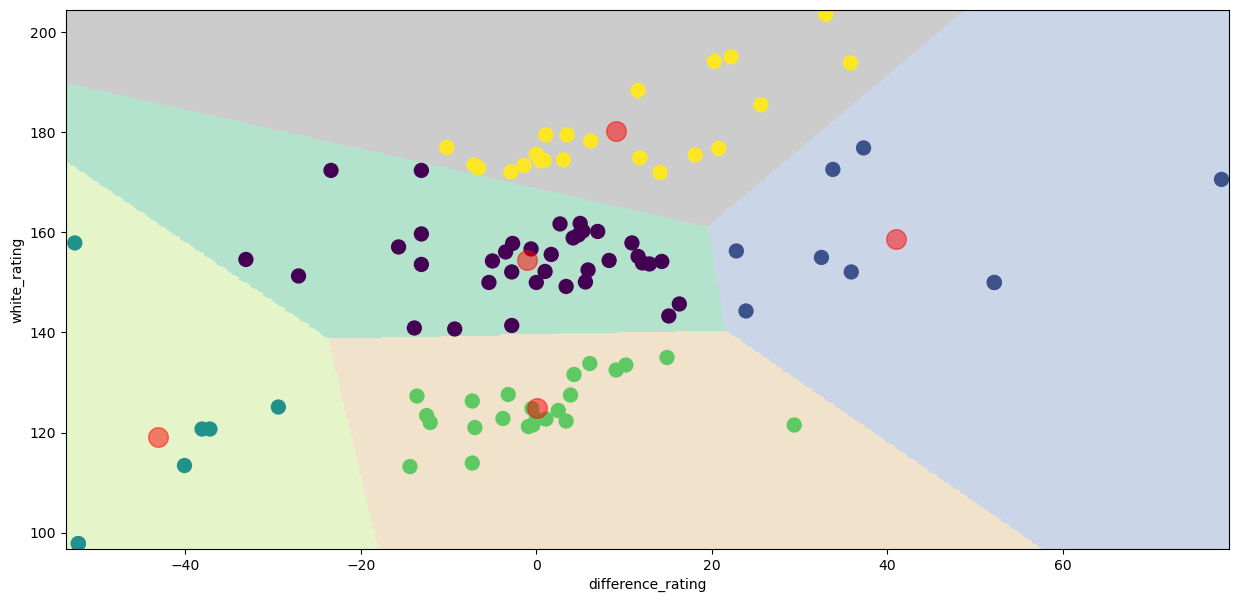

In [112]:
plt.figure(1 , figsize = (15 , 7) )
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'difference_rating' ,y = 'white_rating' , data = games , c = labels1 , 
            s = 100 )
plt.scatter(x = centroids1[: , 0] , y =  centroids1[: , 1] , s = 200 , c = 'red' , alpha = 0.5)
plt.ylabel('white_rating') , plt.xlabel('difference_rating')
plt.show()

На основе полученных групп можно сделать некоторые выводы - если у игроков приблизительно равный рейтинг, то партии могут длится как малое количество ходов, так и большое, в то время как у игроков с сильно отличающимся рейтингом партии зачастую дляться меньше. По количеству точек принадлежащим к разным кластерам можно сделать вывод о том, что система подбора партий старается подбирать соберника со схожим рейтингом и системе становится сложнее это сделать с уменьшением или увеличением рейтинга игрока относительно стартовых 1500.